In [1]:
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
usps_train = datasets.USPS(root="./data", train=True, transform=ToTensor(), download=True)

In [3]:
device = 'cuda'

In [4]:
class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(usps_train):
    if len(class_indices[label]) < 500:
        class_indices[label].append(idx)

# Collect indices for the final dataset
final_indices = []
for indices in class_indices.values():
    final_indices.extend(indices)

# Subset the dataset
train_dataset = Subset(usps_train, final_indices)

# DataLoader
minibatches = DataLoader(train_dataset, batch_size=500, shuffle=True)

print(f"Number of samples in training dataset: {len(train_dataset)}")

Number of samples in training dataset: 5000


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=2)
        self.a = nn.Tanh()
        self.s = nn.Sigmoid()

    def forward(self, X):
        X = self.a(self.conv1(X))
        X = self.a(self.conv2(X))
        return self.s(self.conv3(X))[:, :, 0, 0]

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels=10, out_channels=16, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.deconv2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(8)
        self.deconv3 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=4, stride=2)
        self.a = nn.Tanh()

    def forward(self, X):
        X = self.a(self.bn1(self.deconv1(X)))
        X = self.a(self.bn2(self.deconv2(X)))
        X = self.a(self.deconv3(X))
        return X

In [6]:
G = Generator().to(device)
D = Discriminator().to(device)

loss_fn = nn.BCELoss()
optimizerG = torch.optim.SGD(G.parameters(), lr=0.15)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.15)

epochs = 300
CE_D = torch.zeros(epochs)
CE_G = torch.zeros(epochs)

CE_D = torch.zeros(epochs)
CE_G = torch.zeros(epochs)

for epoch in range(epochs):  # Fixed 'epochs' variable conflict
    for X, _ in minibatches:
        # Loss accumulation for real images
        D.zero_grad()
        X_real = X.to(device)
        Y_real = torch.ones(500).to(device)  # Match size of discriminator output
        outD_real = D(X_real).squeeze()  # Ensure the output is [500]
        loss_real = loss_fn(outD_real, Y_real)

        # Loss accumulation for fake images
        z = torch.randn(500, 10, 1, 1).to(device)
        X_fake = G(z)
        Y_fake = torch.zeros(500).to(device)  # Match size of discriminator output
        outD_fake = D(X_fake).squeeze()  # Ensure the output is [500]
        loss_fake = loss_fn(outD_fake, Y_fake)

        # Gradient descent part for Discriminator
        lossD = loss_real + loss_fake
        lossD.backward()
        optimizerD.step()

        # Training of the Generator
        G.zero_grad()
        z = torch.randn(500, 10, 1, 1).to(device)
        Y = torch.ones(500).to(device)  # Generator tries to fool the discriminator
        outG = G(z)
        outD_fake_for_G = D(outG).squeeze()  # Ensure the output is [500]
        lossG = loss_fn(outD_fake_for_G, Y)
        lossG.backward()
        optimizerG.step()

    # Log the losses
    CE_D[epoch] = lossD.item()
    CE_G[epoch] = lossG.item()
    print(f"Epoch {epoch + 1}/5, Loss_D: {CE_D[epoch]:.4f}, Loss_G: {CE_G[epoch]:.4f}")

Epoch 1/5, Loss_D: 1.3223, Loss_G: 0.7737
Epoch 2/5, Loss_D: 0.9686, Loss_G: 0.8117
Epoch 3/5, Loss_D: 1.6175, Loss_G: 0.3981
Epoch 4/5, Loss_D: 1.2919, Loss_G: 0.8679
Epoch 5/5, Loss_D: 1.3674, Loss_G: 0.7046
Epoch 6/5, Loss_D: 1.3895, Loss_G: 0.6844
Epoch 7/5, Loss_D: 1.3892, Loss_G: 0.6928
Epoch 8/5, Loss_D: 1.3183, Loss_G: 0.7325
Epoch 9/5, Loss_D: 1.3522, Loss_G: 0.6844
Epoch 10/5, Loss_D: 1.3700, Loss_G: 0.5863
Epoch 11/5, Loss_D: 1.3721, Loss_G: 0.6592
Epoch 12/5, Loss_D: 1.3764, Loss_G: 0.6857
Epoch 13/5, Loss_D: 1.3989, Loss_G: 0.5143
Epoch 14/5, Loss_D: 1.3641, Loss_G: 0.6856
Epoch 15/5, Loss_D: 1.3784, Loss_G: 0.6571
Epoch 16/5, Loss_D: 1.4265, Loss_G: 0.5691
Epoch 17/5, Loss_D: 1.3755, Loss_G: 0.6102
Epoch 18/5, Loss_D: 1.3699, Loss_G: 0.6429
Epoch 19/5, Loss_D: 1.3756, Loss_G: 0.5885
Epoch 20/5, Loss_D: 1.3712, Loss_G: 0.6688
Epoch 21/5, Loss_D: 1.3658, Loss_G: 0.6486
Epoch 22/5, Loss_D: 1.3738, Loss_G: 0.6384
Epoch 23/5, Loss_D: 1.3743, Loss_G: 0.5791
Epoch 24/5, Loss_D: 

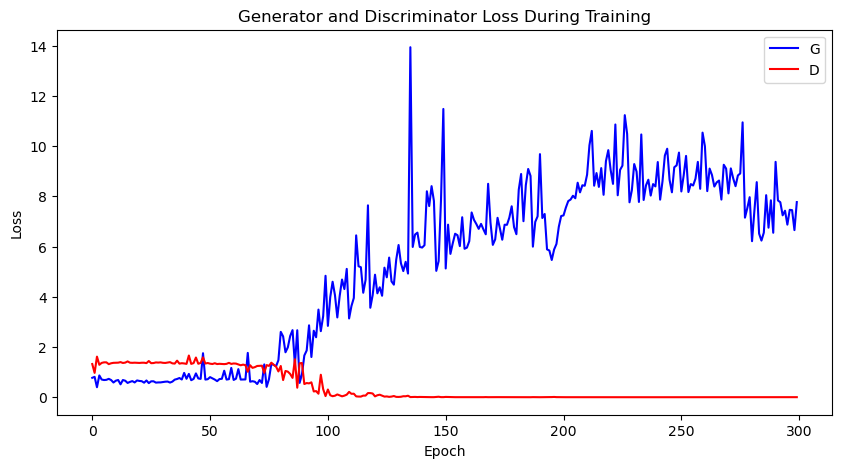

In [7]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(CE_G.numpy(), label="G", color='blue')
plt.plot(CE_D.numpy(), label="D", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

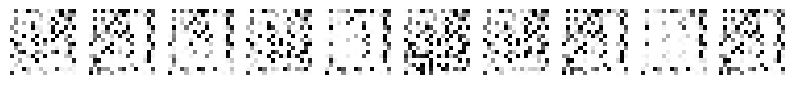

In [9]:
G.eval()  # Set the generator to evaluation mode
generated = G(torch.randn(10, 10, 1, 1).to(device))

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    # Remove channel dimension by indexing [0]
    plt.imshow(generated[i, 0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')  # Hide axes for better visualization
plt.show()
